In [1]:
from sqlalchemy import create_engine
import pymysql
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
import numpy as np
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn import tree

In [2]:
######### QUERIES
query = """
select p.playerID, 
		b.B_AB, b.B_R, b.B_H, b.B_HR, b.B_RBI, b.B_SB, b.B_SO,
        pi.PI_W, pi.PI_L, pi.PI_G, pi.PI_CG, pi.PI_SV, pi.PI_H, 
			pi.PI_ER, pi.PI_HR, pi.PI_BB, pi.PI_SO, pi.PI_ERA, pi.PI_R,
        h.inducted
from 
lahmansbaseballdb.people as p 
left join
(select playerID, max(inducted) as inducted 
	from lahmansbaseballdb.halloffame hof
	where yearid = (select max(yearid) from lahmansbaseballdb.halloffame hof2 where hof.playerID = hof2.playerID)
	group by playerID) as h on p.playerId = h.playerID
left join 
(select playerID, sum(AB) as B_AB, sum(R) as B_R, sum(H) as B_H, sum(HR) as B_HR, 
		sum(RBI) as B_RBI, sum(SB) as B_SB, sum(SO) as B_SO 
	from lahmansbaseballdb.batting 
    group by playerID) as b on p.playerID = b.playerID
left join
(select playerID, sum(W) as PI_W, sum(L) as PI_L, sum(G) as PI_G, sum(CG) as PI_CG, 
		sum(SV) as PI_SV, sum(H) as PI_H, sum(ER) as PI_ER, sum(HR) as PI_HR, 
        sum(BB) as PI_BB, sum(SO) as PI_SO, sum(ERA) as PI_ERA, sum(R) as PI_R
	from lahmansbaseballdb.pitching 
    group by playerID) as pi on p.playerID = pi.playerID
;
"""

In [3]:
sqlEngine = create_engine('mysql+pymysql://root:@127.0.0.1', pool_recycle=3600)
dbConnection    = sqlEngine.connect()
pd.set_option('display.expand_frame_repr', False)


In [4]:
hallOfFamePlayerID = pd.read_sql("select distinct(playerID) from lahmansbaseballdb.halloffame", dbConnection);

In [5]:
people = pd.read_sql("select * from lahmansbaseballdb.people", dbConnection);

In [7]:
nominatedList = []
for index, row in people.iterrows():
    nominatedList.append(hallOfFamePlayerID["playerID"].str.contains(row["playerID"]).any())

print(len(nominatedList))
people["nominated"] = nominatedList

19878


In [8]:
people.nominated.value_counts()



False    18598
True      1280
Name: nominated, dtype: int64

In [194]:
people.throws.value_counts()

R    15093
L     3807
S        1
Name: throws, dtype: int64

In [207]:
valuableFeaturesPeople = people[["weight", "height", "bats", "throws", "debut", "nominated"]]
valuableFeaturesPeople = valuableFeaturesPeople.dropna(how='any',axis=0)

# valuableFeaturesPeople["batsInt"] = np.where(valuableFeaturesPeople["bats"] == "R", 1, 0)
# valuableFeaturesPeople["throwsInt"] = np.where(valuableFeaturesPeople["bats"] == "R", 1, 0)

In [208]:
col         = 'bats'
conditions  = [ valuableFeaturesPeople[col] == "R", valuableFeaturesPeople[col] == "L" , valuableFeaturesPeople[col] == "B"]
choices     = [ 3331, 2232, 3121]
valuableFeaturesPeople["batsInt"] = np.select(conditions, choices, default=np.nan)

In [209]:
col         = 'throws'
conditions  = [ valuableFeaturesPeople[col] == "R", valuableFeaturesPeople[col] == "L" , valuableFeaturesPeople[col] == "S"]
choices     = [1, 20, 3212]
valuableFeaturesPeople["throwsInt"] = np.select(conditions, choices, default=np.nan)

In [210]:
shuffledPeople = shuffle(valuableFeaturesPeople)

In [211]:
eightyPercentIdx = round(len(people) * 0.8)

trainSet = shuffledPeople.iloc[0:eightyPercentIdx]
testSet = shuffledPeople.iloc[eightyPercentIdx:]



In [212]:
trainSet

,weight,height,bats,throws,debut,nominated,batsInt,throwsInt
4398,180.0,72.0,R,R,2019-08-02,False,3331.0,1.0
16906,210.0,74.0,L,L,2015-09-05,False,2232.0,20.0
15850,210.0,70.0,L,R,1948-09-29,False,2232.0,1.0
19329,175.0,71.0,R,R,1951-09-18,False,3331.0,1.0
18521,174.0,73.0,R,R,1956-09-23,False,3331.0,1.0
...,...,...,...,...,...,...,...,...
8950,170.0,73.0,L,R,1973-04-24,False,2232.0,1.0
18060,185.0,75.0,R,R,2018-08-13,False,3331.0,1.0
16328,190.0,71.0,R,R,1988-09-03,True,3331.0,1.0
547,190.0,74.0,R,R,2003-08-03,False,3331.0,1.0


In [213]:
print(testSet.iloc[0].name)
print(trainSet.iloc[-1].name)

19085
4417


In [214]:
# train_X = trainSet[["weight", "height", "bats", "throws", "debut"]]
train_X = trainSet[["weight", "height", "batsInt", "throwsInt"]]
train_Y = trainSet[["nominated"]]

test_X = testSet[["weight", "height", "batsInt", "throwsInt"]]
test_Y = testSet[["nominated"]]

In [215]:
train_X

,weight,height,batsInt,throwsInt
4398,180.0,72.0,3331.0,1.0
16906,210.0,74.0,2232.0,20.0
15850,210.0,70.0,2232.0,1.0
19329,175.0,71.0,3331.0,1.0
18521,174.0,73.0,3331.0,1.0
...,...,...,...,...
8950,170.0,73.0,2232.0,1.0
18060,185.0,75.0,3331.0,1.0
16328,190.0,71.0,3331.0,1.0
547,190.0,74.0,3331.0,1.0


In [216]:
clf = DecisionTreeClassifier()
clf = clf.fit(train_X, train_Y)

In [217]:
y_pred = clf.predict(test_X)



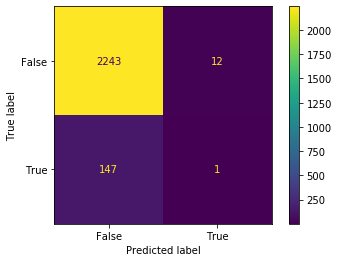

In [218]:
plot_confusion_matrix(clf, test_X, test_Y)

In [219]:
confusion_matrix(test_Y, y_pred)

array([[2243,   12],
       [ 147,    1]])

[Text(193.62716236187023, 212.71304347826086, 'X[0] <= 209.5\ngini = 0.125\nsamples = 15902\nvalue = [14841, 1061]'),
 Text(76.67952077887358, 203.2591304347826, 'X[0] <= 126.0\ngini = 0.136\nsamples = 13095\nvalue = [12137, 958]'),
 Text(2.2489733840304185, 193.80521739130435, 'X[1] <= 68.0\ngini = 0.375\nsamples = 8\nvalue = [6, 2]'),
 Text(1.9095057034220533, 184.3513043478261, 'gini = 0.0\nsamples = 4\nvalue = [4, 0]'),
 Text(2.588441064638783, 184.3513043478261, 'X[0] <= 98.0\ngini = 0.5\nsamples = 4\nvalue = [2, 2]'),
 Text(2.2489733840304185, 174.89739130434782, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(2.9279087452471484, 174.89739130434782, 'X[0] <= 122.5\ngini = 0.444\nsamples = 3\nvalue = [1, 2]'),
 Text(2.588441064638783, 165.44347826086957, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(3.267376425855513, 165.44347826086957, 'X[2] <= 2781.5\ngini = 0.5\nsamples = 2\nvalue = [1, 1]'),
 Text(2.9279087452471484, 155.98956521739132, 'gini = 0.0\nsamples = 1\nvalue =

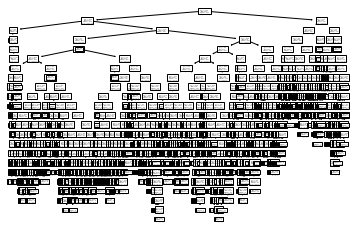

In [220]:
tree.plot_tree(clf)